# [데이터 분석] 내 캐릭터 명성 높이기 프로젝트

## 문제인식

던전앤파이터를 시작한지 한달이 되어가고 있다. `키메라`라는 직업이 내 눈에 매력적으로 다가와 본캐로 잡아 아라드 패스와 패키지를 구매하여 키우고 있다. 베누스와 안개신을 쩔 받으면서 키우고 있으나, 명성과 딜을 높여 스스로 레이드를 뛰는 것을 목표로 가지고 있다. 하지만 에픽무기를 먹은 이후 명성 47000에서 올리는 것에 한계를 느꼈다.

던전엔파이터 게임 내에 가이드를 제공하고 있는 추천 아이템은 `종결 아이템`이며 유튜브를 봐도 어디부터 손을 봐야될 지 감을 잡을 수가 없었다. 그래서 본 프로젝트는 내 캐릭터보다 높은 명성의 캐릭터는 어떻게 템 세팅이 되어있고 어디부터 템을 맞춰야 싸게 맞추어 나갈 수 있는지 분석하고자 한다.
추가적으로 명성은 높으나 나와 비슷한 장비를 장착한 캐릭터는 어떻게 명성을 높였는지 확인하고자 한다.

- 기간: 2025.07.07

- 현재 종결 부분
    - 크리쳐 -> but 기간제
    - 칭호
    - 아바타(피부, 오라 제외)

- 가지고 있는 부분
    - 패스권(무재한 변환)
    - 1700만 골드
    - 이벤트 재화(상점에서 구매 가능) -> 버프 강화 장착 장비 구매 가능(최대 2개)

- 필요한 부분
    - 크리쳐 or 오라 -> 기간제 대비
    - 피부 아바타 엠블럼(그 전에 피부 아바타 소캣 뚫어야함)
    - 버프 강화 부분(크리쳐 제외)

- 요약
    - 명성을 높이는 데 한계를 느꼈다.
    - 내 캐릭터보다 높은 명성을 가진 캐릭터를 분석하여 템세팅을 효율적으로 맞추어 나가고자 한다.
    - 이때 장비 명성은 나와 비슷한 캐릭터를 추출하여 장비 이외 명성을 높인 요인을 파악하고자 한다.


# 1. 내 캐릭터 정보 불러오기

## 1.1 내 캐릭터 기본 정보 조회

In [1]:
# 장바구니 알고리즘
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# 데이터 조작
from collections import Counter
from datetime import date
import pandas as pd
import ast

# 시각화
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import plotly.express as px
import networkx as nx

# API 유틸
from dotenv import load_dotenv
from urllib import parse
from tqdm import tqdm
import requests
import os


plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

font_path = "C:/Windows/Fonts/malgun.ttf"
font_name = fm.FontProperties(fname=font_path).get_name()

In [2]:
# API키 로드
load_dotenv()

api_key = os.getenv('API_KEY')

In [3]:
# 캐릭터 검색

## URL 인코딩
my_character_name = parse.quote("루나틱키메라")
my_server_id = "casillas"

url = f"https://api.neople.co.kr/df/servers/{my_server_id}/characters?characterName={my_character_name}&apikey={api_key}"
response = requests.get(url)

response.json()

{'rows': [{'serverId': 'casillas',
   'characterId': '32b629429b5aefa47845c9ee963c5ef2',
   'characterName': '루나틱키메라',
   'level': 115,
   'jobId': 'b9cb48777665de22c006fabaf9a560b3',
   'jobGrowId': '92da05ec93fb43406e193ffb9a2a629b',
   'jobName': '아처',
   'jobGrowName': '眞 키메라',
   'fame': 47345}]}

In [4]:
my_character_id = "32b629429b5aefa47845c9ee963c5ef2"

In [5]:
# 캐릭터 기본 정보 조회
url = f"https://api.neople.co.kr/df/servers/{my_server_id}/characters/{my_character_id}?apikey={api_key}"
response = requests.get(url)

response.json()

{'serverId': 'casillas',
 'characterId': '32b629429b5aefa47845c9ee963c5ef2',
 'characterName': '루나틱키메라',
 'level': 115,
 'jobId': 'b9cb48777665de22c006fabaf9a560b3',
 'jobGrowId': '92da05ec93fb43406e193ffb9a2a629b',
 'jobName': '아처',
 'jobGrowName': '眞 키메라',
 'fame': 47345,
 'adventureName': '세페G',
 'guildId': '7fce6585dc0085f44d171eb3daed3331',
 'guildName': '사쿠'}

In [129]:
# 캐릭터 능력치 정보 조회
url = f"https://api.neople.co.kr/df/servers/{my_server_id}/characters/{my_character_id}/status?apikey={api_key}"
response = requests.get(url)

response.json()

{'serverId': 'casillas',
 'characterId': '32b629429b5aefa47845c9ee963c5ef2',
 'characterName': '루나틱키메라',
 'level': 115,
 'jobId': 'b9cb48777665de22c006fabaf9a560b3',
 'jobGrowId': '92da05ec93fb43406e193ffb9a2a629b',
 'jobName': '아처',
 'jobGrowName': '眞 키메라',
 'fame': 47345,
 'adventureName': '세페G',
 'guildId': '7fce6585dc0085f44d171eb3daed3331',
 'guildName': '사쿠',
 'buff': [{'name': '모험단 버프',
   'level': 35,
   'status': [{'name': '힘', 'value': 280},
    {'name': '지능', 'value': 280},
    {'name': '체력', 'value': 280},
    {'name': '정신력', 'value': 280}]},
  {'name': '무제한 길드능력치',
   'status': [{'name': '힘', 'value': 60},
    {'name': '지능', 'value': 60},
    {'name': '체력', 'value': 60},
    {'name': '정신력', 'value': 60}]},
  {'name': '기간제 길드능력치',
   'status': [{'name': '힘', 'value': 40},
    {'name': '지능', 'value': 40},
    {'name': '체력', 'value': 40},
    {'name': '정신력', 'value': 40}]}],
 'status': [{'name': 'HP', 'value': 134224},
  {'name': 'MP', 'value': 123120},
  {'name': '물리 방어율', '

## 1.2 내 캐릭터 타임라인 정보(던전 드랍&던전 카드 보상)

In [6]:
# 캐릭터 타임라인 정보 조회(아이템 획득(던전 드랍)) & 아이템 획득(던전 카드 보상)
code = "505,513"
limit = "100"

url = f"https://api.neople.co.kr/df/servers/{my_server_id}/characters/{my_character_id}/timeline?limit={limit}&code={code}&apikey={api_key}"

response = requests.get(url)
time_data = response.json()

flat_data = []
for entry in time_data["timeline"]["rows"]:
    flat_entry = entry.copy()
    nested_data = flat_entry.pop('data')
    flat_entry.update(nested_data)
    flat_data.append(flat_entry)

# DataFrame 생성
timeline_data = pd.DataFrame(flat_data)

# 레전,에픽,태초 아이탬 획득 갯수
timeline_data['itemRarity'].value_counts()

itemRarity
레전더리    33
에픽      13
태초       3
Name: count, dtype: int64

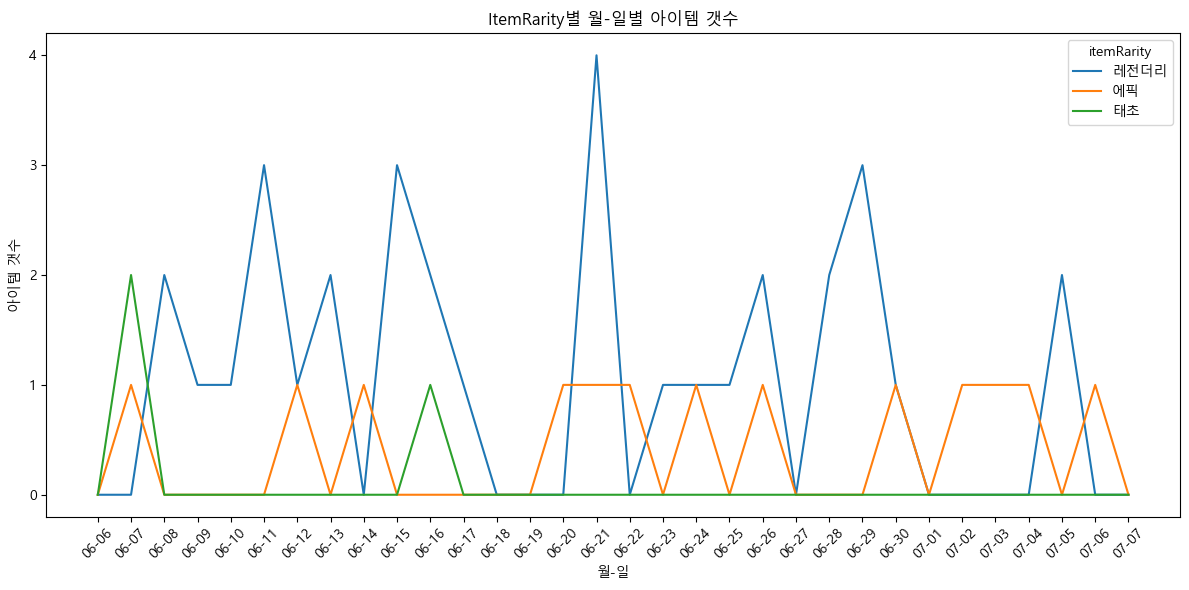

In [7]:
# 날짜 범위 생성 (6월 6일부터 오늘까지)
date_range = pd.date_range(start='2025-06-06', end=date.today())
all_dates = date_range.strftime('%m-%d')

# 'date' 컬럼을 datetime 타입으로 변환
timeline_data['date'] = pd.to_datetime(timeline_data['date'])

# 월-일 문자열 추출
timeline_data['month_day'] = timeline_data['date'].dt.strftime('%m-%d')

# itemRarity별 월-일별 아이템 갯수 집계
count_timeline_data = timeline_data.groupby(['itemRarity', 'month_day']).size().reset_index(name='count')

# 모든 itemRarity와 날짜 조합 생성
item_rarities = count_timeline_data['itemRarity'].unique()
all_combinations = pd.MultiIndex.from_product([item_rarities, all_dates], names=['itemRarity', 'month_day'])

# 기존 데이터 인덱스 설정
indexed_df = count_timeline_data.set_index(['itemRarity', 'month_day'])

# 모든 조합으로 reindex 후 count가 없는 경우 0으로 채우기
reindexed_df = indexed_df.reindex(all_combinations, fill_value=0).reset_index()

# 선그래프 그리기
plt.figure(figsize=(12, 6))

for rarity in item_rarities:
    subset = reindexed_df[reindexed_df['itemRarity'] == rarity]
    plt.plot(subset['month_day'], subset['count'], label=rarity)

ax = plt.gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True)) # y축을 정수로 표시

plt.xlabel('월-일')
plt.ylabel('아이템 갯수')
plt.title('ItemRarity별 월-일별 아이템 갯수')
plt.legend(title='itemRarity')
plt.xticks(rotation=45)
# plt.grid(True)
plt.tight_layout()
plt.show()

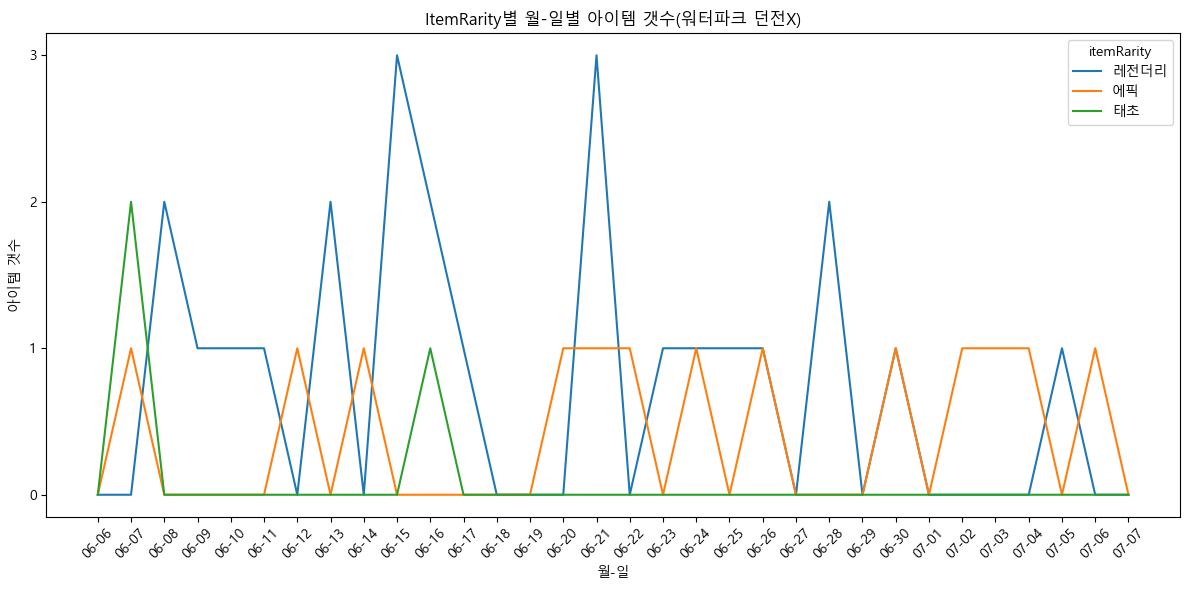

In [8]:
# 날짜 범위 생성 (6월 6일부터 오늘까지)
date_range = pd.date_range(start='2025-06-06', end=date.today())
all_dates = date_range.strftime('%m-%d')

# itemRarity별 월-일별 아이템 갯수 집계
count_timeline_data = timeline_data[timeline_data["dungeonName"]!="워터파크 던전"].groupby(['itemRarity', 'month_day']).size().reset_index(name='count')

# 모든 itemRarity와 날짜 조합 생성
item_rarities = count_timeline_data['itemRarity'].unique()
all_combinations = pd.MultiIndex.from_product([item_rarities, all_dates], names=['itemRarity', 'month_day'])

# 기존 데이터 인덱스 설정
indexed_df = count_timeline_data.set_index(['itemRarity', 'month_day'])

# 모든 조합으로 reindex 후 count가 없는 경우 0으로 채우기
reindexed_df = indexed_df.reindex(all_combinations, fill_value=0).reset_index()

# 선그래프 그리기
plt.figure(figsize=(12, 6))

for rarity in item_rarities:
    subset = reindexed_df[reindexed_df['itemRarity'] == rarity]
    plt.plot(subset['month_day'], subset['count'], label=rarity)

ax = plt.gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True)) # y축을 정수로 표시

plt.xlabel('월-일')
plt.ylabel('아이템 갯수')
plt.title('ItemRarity별 월-일별 아이템 갯수(워터파크 던전X)')
plt.legend(title='itemRarity')
plt.xticks(rotation=45)
# plt.grid(True)
plt.tight_layout()
plt.show()

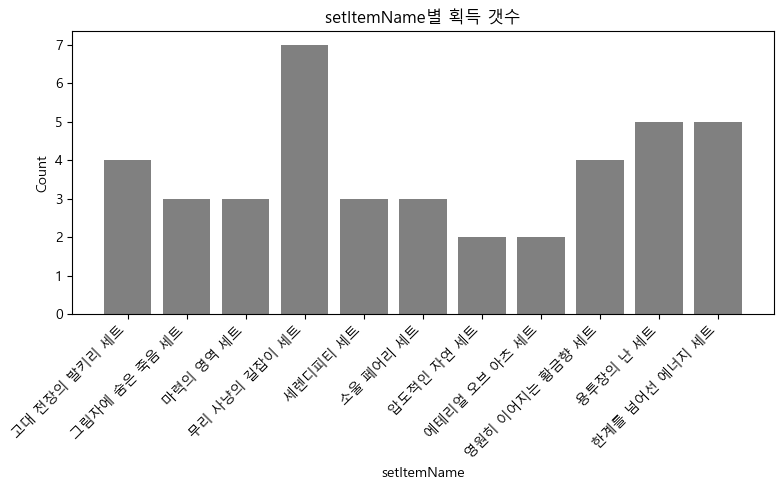

In [9]:
# 획득한 아이템 세트 갯수 확인
item_data = []
exclude_keys = ["itemStatus","tune","itemBuff","hashtag","obtainInfo",""] # 제외 Keys

for item_id in timeline_data["itemId"]:
    url = f"https://api.neople.co.kr/df/items/{item_id}?apikey={api_key}"

    response = requests.get(url)
    item_id_data = response.json()
    filtered = {k: v for k, v in item_id_data.items() if k not in exclude_keys}
    item_data.append(filtered)

set_item_data = pd.DataFrame(item_data)

# setItemName별 개수 집계
count_by_set = set_item_data.groupby('setItemName').size().reset_index(name='count')

# Bar plot 그리기
plt.figure(figsize=(8, 5))
plt.bar(count_by_set['setItemName'], count_by_set['count'], color='gray')

plt.xlabel('setItemName')
plt.ylabel('Count')
plt.title('setItemName별 획득 갯수')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [117]:
# 태초 정보
set_item_data[set_item_data["itemRarity"] == "태초"]

,itemId,itemName,itemRarity,itemTypeId,itemType,itemTypeDetailId,itemTypeDetail,itemAvailableLevel,itemExplain,itemExplainDetail,itemFlavorText,fame,setItemId,setItemName,jobs
28,02003739f9c1d138bc25b4e5fcc60a7c,과충전 - 한계를 여는 열쇠 목걸이,태초,e490f8cce6bacd43bef1e2f5e0c4943d,액세서리,390e3966118b0c466ce9f8eae45e1629,목걸이,115,모든 속성 강화 +40,모든 속성 강화 +40,한계 돌파. 기존 목소리와 가장 유사한 형태의 파동을 출력합니다.,1400,2877466bc2fc8bedf7799d88167c9fe3,한계를 넘어선 에너지 세트,NaN
46,28fc8eb2f6cd1cde8fefe8aca6a9ceaa,발할라의 여신 발키리 천상 목걸이,태초,e490f8cce6bacd43bef1e2f5e0c4943d,액세서리,390e3966118b0c466ce9f8eae45e1629,목걸이,115,모든 속성 강화 +40,모든 속성 강화 +40,그 어떤 맹수도 감히 견줄 수 없을 정도로 강인하며,1400,854dc8c01b1bc231e132dae5df3c52bc,고대 전장의 발키리 세트,NaN
48,5f0746d290ec872e9d4e66741130bafc,무리의 길잡이 팔목 보호대,태초,e490f8cce6bacd43bef1e2f5e0c4943d,액세서리,80bddf423629c28c7b4459c328fdffaf,팔찌,115,모든 속성 강화 +50,모든 속성 강화 +50,흩어진 달빛을 하나로 인도할지니,1400,e23286107ba4328af86c83aabc347e9e,무리 사냥의 길잡이 세트,NaN


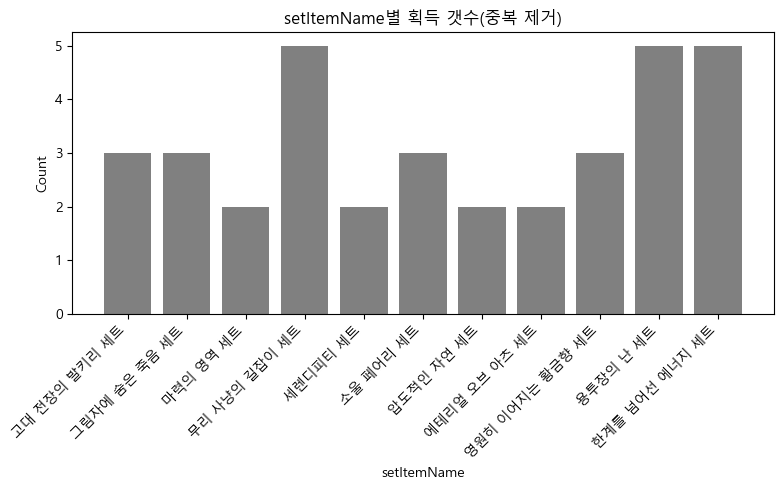

In [119]:
drop_duplicated_item = set_item_data.drop_duplicates(["itemName"], keep="first")
drop_duplicated_count_by_set = drop_duplicated_item.groupby('setItemName').size().reset_index(name='count')

# Bar plot 그리기
plt.figure(figsize=(8, 5))
plt.bar(drop_duplicated_count_by_set['setItemName'], drop_duplicated_count_by_set['count'], color='gray')

plt.xlabel('setItemName')
plt.ylabel('Count')
plt.title('setItemName별 획득 갯수(중복 제거)')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [127]:
# setItemName별 itemRarity별 아이템 개수
drop_duplicated_count_by_set_rarity = drop_duplicated_item.groupby(['setItemName','itemRarity']).size().reset_index(name='count')

fig = px.bar(
    drop_duplicated_count_by_set_rarity,
    x='setItemName',
    y='count',
    color='itemRarity',
    barmode='group',
    title='setItemName별 itemRarity별 아이템 개수'
)
fig.update_yaxes(tickformat=",d", dtick=1)
fig.show()

### 내 캐릭터 타임라인 정리

- 태초를 초반에 먹은 이후로는 획득한 이력이 없다. 또한, 태초 세트가 각각 다르다.
- 레전더리 -> 에픽 -> 태초 순으로 확득량을 볼 수 있다.
- 워터파크 던전에서는 레전더리만 먹었다.
- 중복을 제외하고 가장 많이 먹은 세트는 "무리 사냥의 길잡이", "용투장의 난", "한계를 넘어선 에너지"로 보인다. 
- 레어리티별로 확인 결과 "무리 사냥의 길잡이", "한계를 넘어선 에너지"가 높은 레어리티 획득을 보인다.

결과: "무리 사냥의 길잡이", "용투장의 난", "한계를 넘어선 에너지"위 3세트가 높은 획득율을 보이고 있다.


## 1.3 내 캐릭터 장비 조회

In [10]:
# 내 캐릭터 장비 조회
url = f"https://api.neople.co.kr/df/servers/{my_server_id}/characters/{my_character_id}/equip/equipment?apikey={api_key}"

response = requests.get(url)

equipment_data = response.json()
my_equipment_data = pd.DataFrame(equipment_data["equipment"])

my_equipment_data.head()
# 내 캐릭터 장비 명성 합
my_sum_fame = 0

for idx, equipment_row in my_equipment_data.iterrows():
    equipment_id = equipment_row["itemId"]
    url = f"https://api.neople.co.kr/df/items/{equipment_id}?apikey={api_key}"

    response = requests.get(url)
    item = response.json()
    my_sum_fame += item["fame"]

print("내 장비 명성 : ",my_sum_fame)

내 장비 명성 :  22123


# 2. 명성 48000 - 50000 캐릭터 정보 비교

## 2.1 명성 48000 - 50000 캐릭터 장비 조회

In [ ]:
# 명성 48000 ~ 50000까지 50단위로 200명씩 추출(25.07.07)
server_id_all = "all"
minfame = "49900"
maxfame = "50000"
job_id = "b9cb48777665de22c006fabaf9a560b3"
job_grow_id = "92da05ec93fb43406e193ffb9a2a629b"
is_buff = "false"
limit = "200"

data = []

for i in tqdm(range(0, 2000,50)):
    min_fame = 48000 + i
    max_fame = 48000 + i + 50
    url = f"https://api.neople.co.kr/df/servers/{server_id_all}/characters-fame?minFame={min_fame}&maxFame={max_fame}&jobId={job_id}&jobGrowId={job_grow_id}&limit={limit}&apikey={api_key}"

    response = requests.get(url)

    if response.status_code != 200: continue
    
    rank_data = response.json()
    rows = rank_data["rows"]
    data.extend(rows)

rank_df = pd.DataFrame(data)

# 각 캐릭터 장비 정보 추출
equipment_list = []

for idx, personal in tqdm(rank_df.iterrows()):
    personal_serverid = personal["serverId"]
    personal_characterid = personal["characterId"]
    personal_serverid = personal["serverId"]
    url = f"https://api.neople.co.kr/df/servers/{personal_serverid}/characters/{personal_characterid}/equip/equipment?apikey={api_key}"

    response = requests.get(url)
    
    if response.status_code != 200: continue

    personal_equipment_data = response.json()
    for equipment in personal_equipment_data["equipment"]:
        row_data = {
            "characterId": personal_characterid,
            "serverId": personal_serverid
        }
        equipment.update(row_data)
        equipment_list.append(equipment)

equipment_data = pd.DataFrame(equipment_list)
equipment_data.head()

100%|██████████| 40/40 [00:05<00:00,  7.53it/s]
7758it [08:07, 15.90it/s]


,slotId,slotName,itemId,itemName,itemTypeId,itemType,itemTypeDetailId,itemTypeDetail,itemAvailableLevel,itemRarity,...,refine,asrahanOption,characterId,serverId,fusionOption,upgradeInfo,tune,expiredDate,skin,fixedOption
0,WEAPON,무기,39bde6ef417cc973d50540604feca327,첫 물결,4ffb6f14b86f5c818a925bf58022686e,무기,6f19a902e802b680a5c8beeb2989208c,컴파운드 보우,110,태초,...,8,"{'options': [{'name': '새하얀 눈의 성단', 'step': 20,...",c8c7ec460b234009124763e88bc247a6,cain,NaN,NaN,NaN,NaN,NaN,NaN
1,TITLE,칭호,74711128d2d0739c4f5d38b488d2be2c,[EVENT]세리아의 풍성한 선물 Ver.2,e490f8cce6bacd43bef1e2f5e0c4943d,액세서리,691933a06ff114348a7db936fb0aec66,칭호,1,레어,...,0,NaN,c8c7ec460b234009124763e88bc247a6,cain,NaN,NaN,NaN,NaN,NaN,NaN
2,JACKET,상의,8620ea36303db8fe485762e3e1b56883,때 묻지 않은 정화 상의,b09752bfff1935188ea2735cd925a872,방어구,3da92241d44bdafcf7554057e6479c83,상의,115,레전더리,...,0,NaN,c8c7ec460b234009124763e88bc247a6,cain,"{'options': [{'buff': 2066, 'skillBonusRate': ...","{'itemId': 'd8f457479508ba3159430e137d99f52f',...","[{'level': 0, 'setPoint': 165}]",NaN,NaN,NaN
3,SHOULDER,머리어깨,2444288a5ba59fe11dacd68b811ffc18,때 묻지 않은 정화 어깨,b09752bfff1935188ea2735cd925a872,방어구,f2976a25a516451e3e8667bac328b308,머리어깨,115,레전더리,...,0,NaN,c8c7ec460b234009124763e88bc247a6,cain,"{'options': [{'buff': 2610, 'explain': '최종 데미지...","{'itemId': '3f43639f70a6ee3eb1bbb5856117322c',...","[{'level': 0, 'setPoint': 165}]",NaN,NaN,NaN
4,PANTS,하의,5a4809553cd2957bc784cae0cfb5799d,때 묻지 않은 정화 하의,b09752bfff1935188ea2735cd925a872,방어구,7c4b28699ae7994798289f187d519992,하의,115,레전더리,...,0,NaN,c8c7ec460b234009124763e88bc247a6,cain,"{'options': [{'buff': 2610, 'explain': '최종 데미지...","{'itemId': 'a9f16836cba7534104493f8a3e0a3471',...","[{'level': 0, 'setPoint': 165}]",NaN,NaN,NaN


In [23]:
# 장비 명성 조회
duplicated_equipment_data = equipment_data.drop_duplicates(subset="itemId")

equipment_list = []
for idx, equipment_row in tqdm(duplicated_equipment_data.iterrows()):
    equipment_id = equipment_row["itemId"]
    url = f"https://api.neople.co.kr/df/items/{equipment_id}?apikey={api_key}"

    response = requests.get(url)
    item = response.json()
    row_data = {
        "itemId" : equipment_id,
        "fame" : item["fame"]
    }
    equipment_list.append(row_data)

fame_equipment_data = pd.DataFrame(equipment_list)
equipment_df = pd.merge(equipment_data, fame_equipment_data, on="itemId", how="left")

# 각 유저별 종합 장비 명성 조회
equipment_fame = equipment_df.groupby(["characterId","serverId"]).sum("fame").reset_index()

fig = px.histogram(equipment_fame, x="fame")
fig.add_vline(x=my_sum_fame, line_dash='dash', line_color='firebrick')
fig.update_xaxes(tickformat=",d")
fig.show()

568it [00:30, 18.39it/s]


In [13]:
# 장비 명성 내림차순
equipment_fame.sort_values("fame", ascending=False)

,characterId,serverId,itemAvailableLevel,reinforce,refine,expiredDate,fame
5487,b37912ef3dd22e09db16cf1ebffd0575,cain,2762,24,16,0.0,49980
4716,9b763faa8807fdc12c924f5eb0662694,cain,2762,24,16,0.0,49780
952,1e3531b3c774a27ab1637cce8698b115,cain,2762,68,16,0.0,49646
1323,2a94288fa80e50542aea66ba8900a92d,cain,2762,24,16,0.0,49580
5027,a4ec3b4ac11157c50b3104f0e9c0f01b,bakal,2762,24,16,0.0,44580
...,...,...,...,...,...,...,...
435,0d7340c34f0bdf7a33cd4233caad1f08,cain,1376,26,8,0.0,16221
355,0aa0ebe4196840f6ecb61b27a369922b,cain,1376,12,8,0.0,16088
4264,8cd439c9272f38e1cd7e7a77af908f01,casillas,1266,0,0,0.0,13590
3988,8367b9cceaa6435a0ef95bdac7c45d4d,cain,1266,20,0,0.0,13490


# 3. 근접 명성 캐릭터 분석

In [22]:
# 장착 장비 명성 (21600 - 22390) 캐릭터 추출
fame_ranker = equipment_fame[(equipment_fame["fame"] >= 21600) & (equipment_fame["fame"] <= 22390)]
fame_ranker.describe()

,itemAvailableLevel,reinforce,refine,expiredDate,fame
count,3813.000000,3813.000000,3813.000000,3.813000e+03,3813.000000
mean,1380.997377,11.711251,7.923420,6.439740e+06,22036.476790
std,0.161945,9.525014,0.671258,1.060952e+08,174.789603
min,1371.000000,0.000000,0.000000,0.000000e+00,21623.000000
25%,1381.000000,12.000000,8.000000,0.000000e+00,21890.000000
50%,1381.000000,12.000000,8.000000,0.000000e+00,22023.000000
75%,1381.000000,12.000000,8.000000,0.000000e+00,22190.000000
max,1381.000000,122.000000,8.000000,1.753909e+09,22390.000000


## 3.1 근접 명성 장착 장비 캐릭터 "장착 아바타" 분석

In [15]:
# 각 캐릭터 아바타 정보 추출
avatar_list = []

for idx, personal in tqdm(fame_ranker.iterrows()):
    personal_serverid = personal["serverId"]
    personal_characterid = personal["characterId"]
    url = f"https://api.neople.co.kr/df/servers/{personal_serverid}/characters/{personal_characterid}/equip/avatar?apikey={api_key}"

    response = requests.get(url)
    
    if response.status_code != 200: continue

    personal_avatar_data = response.json()
    for avatar in personal_avatar_data["avatar"]:
        row_data = {
            "characterId": personal_characterid
        }
        avatar.update(row_data)
        avatar_list.append(avatar)

avatar_data = pd.DataFrame(avatar_list)
avatar_data.head()

3813it [03:54, 16.29it/s]


,slotId,slotName,itemId,itemName,itemRarity,clone,optionAbility,emblems,characterId
0,HEADGEAR,모자 아바타,68779826ad943f40e11ca6cf64a1f8b7,키메라의 망원조준경,커먼,"{'itemId': None, 'itemName': None}",정신력 45 증가,None,0006341f03cde14187886e6c8a985395
1,HAIR,머리 아바타,0d51057bf5ac57c9577720326bdb7a28,키메라의 브릿지 보브컷,커먼,"{'itemId': None, 'itemName': None}",정신력 45 증가,None,0006341f03cde14187886e6c8a985395
2,FACE,얼굴 아바타,15ba526959df07d75b7db3a4ed5c6a73,키메라의 렌즈와 메이크업,커먼,"{'itemId': None, 'itemName': None}",공격 속도 5.0% 증가,None,0006341f03cde14187886e6c8a985395
3,JACKET,상의 아바타,52131fa39da2678649e83ba2d7848d03,키메라의 군장 자켓,커먼,"{'itemId': None, 'itemName': None}",큐브 오브 마테리얼리즘 스킬Lv +1,None,0006341f03cde14187886e6c8a985395
4,PANTS,하의 아바타,e5e1ef94659b7d40ed07f23c87b16d71,키메라의 골지니트 치마,커먼,"{'itemId': None, 'itemName': None}",HP MAX 280 증가,None,0006341f03cde14187886e6c8a985395


In [16]:
avatar_data["slotName"].value_counts()

slotName
오라 아바타       3811
상의 아바타       3725
하의 아바타       3725
모자 아바타       3724
신발 아바타       3723
얼굴 아바타       3723
머리 아바타       3722
허리 아바타       3721
목가슴 아바타      3720
무기 아바타       3582
스킨 아바타       1027
오라 스킨 아바타      16
Name: count, dtype: int64

In [27]:
# 스킨 아바타 엠블럼 분석
avatar_skin = avatar_data[(avatar_data["slotName"] == "스킨 아바타") & (avatar_data["emblems"].notnull())]
print("엠블럼을 쓰는 캐릭터 수: ",len(avatar_skin))
skin_list = []

for _, skin in tqdm(avatar_skin.iterrows()):
    emblems = skin["emblems"]
    character_id = skin["characterId"]
    for emblems_no in emblems:
        row_data = {
            "characterId" : character_id
        }
        emblems_no.update(row_data)
        skin_list.append(emblems_no)
    
skin_df = pd.DataFrame(skin_list)
skin_df

엠블럼을 쓰는 캐릭터 수:  253


253it [00:00, 57715.59it/s]


,slotNo,slotColor,itemId,itemName,itemRarity,characterId
0,1,다색,fee7290cb595e601726e58cf0dd50e3f,찬란한 붉은빛 엠블렘[힘],유니크,01630028479699dcd0d3221b22fccea6
1,2,다색,fee7290cb595e601726e58cf0dd50e3f,찬란한 붉은빛 엠블렘[힘],유니크,01630028479699dcd0d3221b22fccea6
2,1,다색,0407c1513c00bbc1cede1232b4b07df8,빛나는 녹색빛 엠블렘[회피율],언커먼,016e1fda31a42911c2b61f1219e973fc
3,1,다색,244e0c6469f2d85f94f47d422a73c9c8,찬란한 붉은빛 엠블렘[힘],유니크,0238da07f7d6c41bf56472dc2c288dcc
4,2,다색,244e0c6469f2d85f94f47d422a73c9c8,찬란한 붉은빛 엠블렘[힘],유니크,0238da07f7d6c41bf56472dc2c288dcc
...,...,...,...,...,...,...
495,2,다색,bd1b5a935ec9aefd8fdc296b1cac3930,찬란한 붉은빛 엠블렘[힘],유니크,fd714c34faac5e4640fc788d70fb146e
496,1,다색,fd9d6605cb0fed203d2d107f34d2a21d,빛나는 붉은빛 엠블렘[힘],언커먼,fe0d2889add99ae264090aeaeaac67e5
497,2,다색,fd9d6605cb0fed203d2d107f34d2a21d,빛나는 붉은빛 엠블렘[힘],언커먼,fe0d2889add99ae264090aeaeaac67e5
498,1,다색,bd1b5a935ec9aefd8fdc296b1cac3930,찬란한 붉은빛 엠블렘[힘],유니크,ff828280b366c971bb383f853b2cdc85


In [28]:
# 단일 스킨 아이템 엠블럼 빈도
skin_group = skin_df.groupby("characterId")["itemName"].apply(list)
all_items = [item for sublist in skin_group for item in sublist]
item_counts = Counter(all_items)
print(item_counts.most_common(10))

[('찬란한 붉은빛 엠블렘[힘]', 155), ('화려한 붉은빛 엠블렘[힘]', 110), ('빛나는 붉은빛 엠블렘[힘]', 77), ('화려한 듀얼 엠블렘[힘 + 물리크리티컬]', 20), ('빛나는 녹색빛 엠블렘[물리크리티컬]', 19), ('화려한 녹색빛 엠블렘[물리크리티컬]', 19), ('찬란한 녹색빛 엠블렘[물리크리티컬]', 13), ('찬란한 노란빛 엠블렘[공격속도]', 12), ('빛나는 붉은빛 엠블렘[정신력]', 11), ('빛나는 다색 엠블렘[모든속성저항]', 5)]


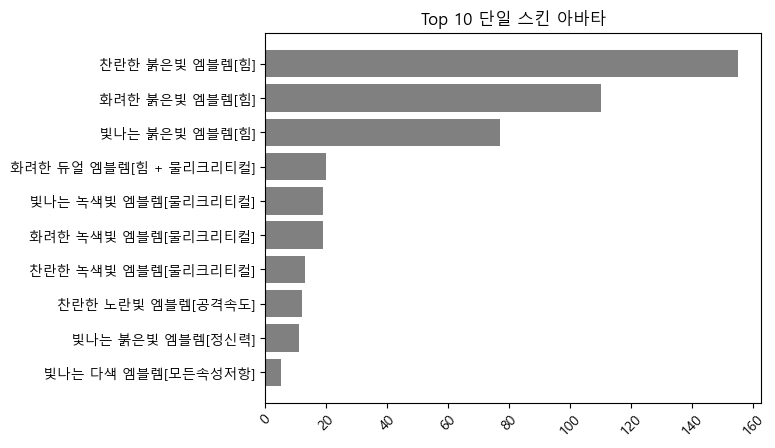

In [29]:
top_items = item_counts.most_common(10)
names, counts = zip(*top_items)
plt.barh(names, counts, color="gray")
plt.xticks(rotation=45)
plt.gca().invert_yaxis()
plt.title("Top 10 단일 스킨 아바타")
plt.show()

In [30]:
# 단일 스킨 아이템 엠블럼 빈도
skin_group = skin_df.groupby("characterId")["itemName"].apply(list)
all_items = [item for sublist in skin_group for item in sublist]
item_counts = Counter(all_items)
print(item_counts.most_common(10))

[('찬란한 붉은빛 엠블렘[힘]', 155), ('화려한 붉은빛 엠블렘[힘]', 110), ('빛나는 붉은빛 엠블렘[힘]', 77), ('화려한 듀얼 엠블렘[힘 + 물리크리티컬]', 20), ('빛나는 녹색빛 엠블렘[물리크리티컬]', 19), ('화려한 녹색빛 엠블렘[물리크리티컬]', 19), ('찬란한 녹색빛 엠블렘[물리크리티컬]', 13), ('찬란한 노란빛 엠블렘[공격속도]', 12), ('빛나는 붉은빛 엠블렘[정신력]', 11), ('빛나는 다색 엠블렘[모든속성저항]', 5)]


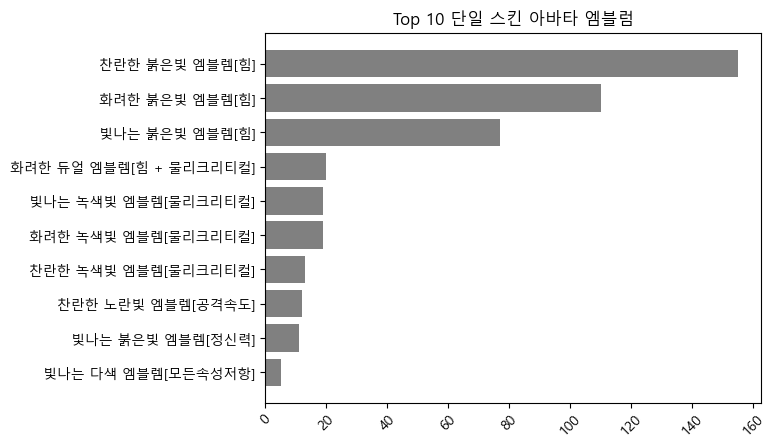

In [31]:
top_items = item_counts.most_common(10)
names, counts = zip(*top_items)
plt.barh(names, counts, color="gray")
plt.xticks(rotation=45)
plt.gca().invert_yaxis()
plt.title("Top 10 단일 스킨 아바타 엠블럼")
plt.show()

In [32]:
# 스킨 아이템 엠블럼 조합 빈도
pair_counts = Counter()

for items in skin_group:
    pair_counts[str(sorted(items))] += 1

print(pair_counts.most_common(10))

[("['찬란한 붉은빛 엠블렘[힘]', '찬란한 붉은빛 엠블렘[힘]']", 77), ("['화려한 붉은빛 엠블렘[힘]', '화려한 붉은빛 엠블렘[힘]']", 55), ("['빛나는 붉은빛 엠블렘[힘]', '빛나는 붉은빛 엠블렘[힘]']", 38), ("['화려한 듀얼 엠블렘[힘 + 물리크리티컬]', '화려한 듀얼 엠블렘[힘 + 물리크리티컬]']", 10), ("['빛나는 녹색빛 엠블렘[물리크리티컬]', '빛나는 녹색빛 엠블렘[물리크리티컬]']", 9), ("['화려한 녹색빛 엠블렘[물리크리티컬]', '화려한 녹색빛 엠블렘[물리크리티컬]']", 9), ("['찬란한 녹색빛 엠블렘[물리크리티컬]', '찬란한 녹색빛 엠블렘[물리크리티컬]']", 6), ("['찬란한 노란빛 엠블렘[공격속도]', '찬란한 노란빛 엠블렘[공격속도]']", 6), ("['빛나는 붉은빛 엠블렘[정신력]', '빛나는 붉은빛 엠블렘[정신력]']", 5), ("['찬란한 듀얼 엠블렘[힘 + 물리크리티컬]', '찬란한 듀얼 엠블렘[힘 + 물리크리티컬]']", 2)]


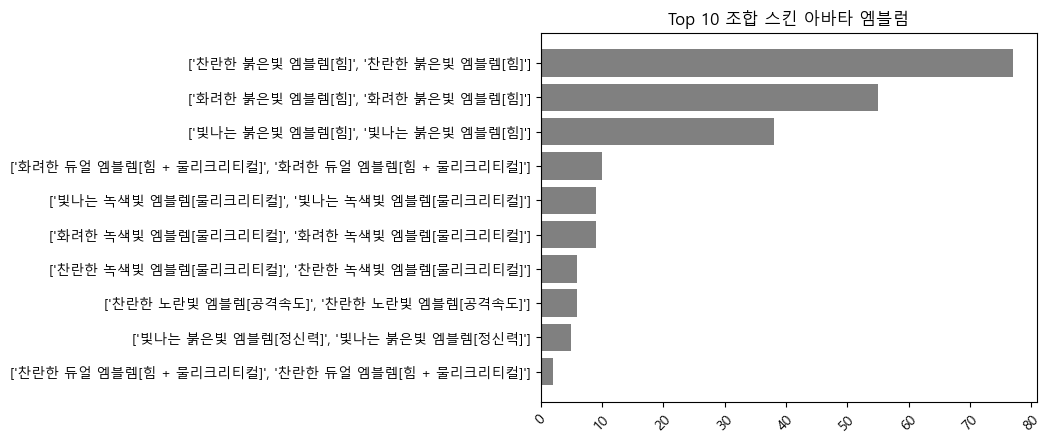

In [33]:
top_items = pair_counts.most_common(10)
names, counts = zip(*top_items)
plt.barh(names, counts, color="gray")
plt.xticks(rotation=45)
plt.gca().invert_yaxis()
plt.title("Top 10 조합 스킨 아바타 엠블럼")
plt.show()

In [34]:
# 엠블럼 연관성
transactions = [x for x in skin_group if isinstance(x, list) and len(x) > 0]
transactions_with_pos = [
    [f"{i+1}:{item}" for i, item in enumerate(tran)]
    for tran in transactions
]

te = TransactionEncoder()
te_ary = te.fit(transactions_with_pos).transform(transactions_with_pos)
basket_df = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = apriori(basket_df, min_support=0.05, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())

          antecedents         consequents   support  confidence      lift
0  (2:빛나는 붉은빛 엠블렘[힘])  (1:빛나는 붉은빛 엠블렘[힘])  0.150198    1.000000  6.487179
1  (1:빛나는 붉은빛 엠블렘[힘])  (2:빛나는 붉은빛 엠블렘[힘])  0.150198    0.974359  6.487179
2  (1:찬란한 붉은빛 엠블렘[힘])  (2:찬란한 붉은빛 엠블렘[힘])  0.304348    0.987179  3.243590
3  (2:찬란한 붉은빛 엠블렘[힘])  (1:찬란한 붉은빛 엠블렘[힘])  0.304348    1.000000  3.243590
4  (1:화려한 붉은빛 엠블렘[힘])  (2:화려한 붉은빛 엠블렘[힘])  0.217391    1.000000  4.600000


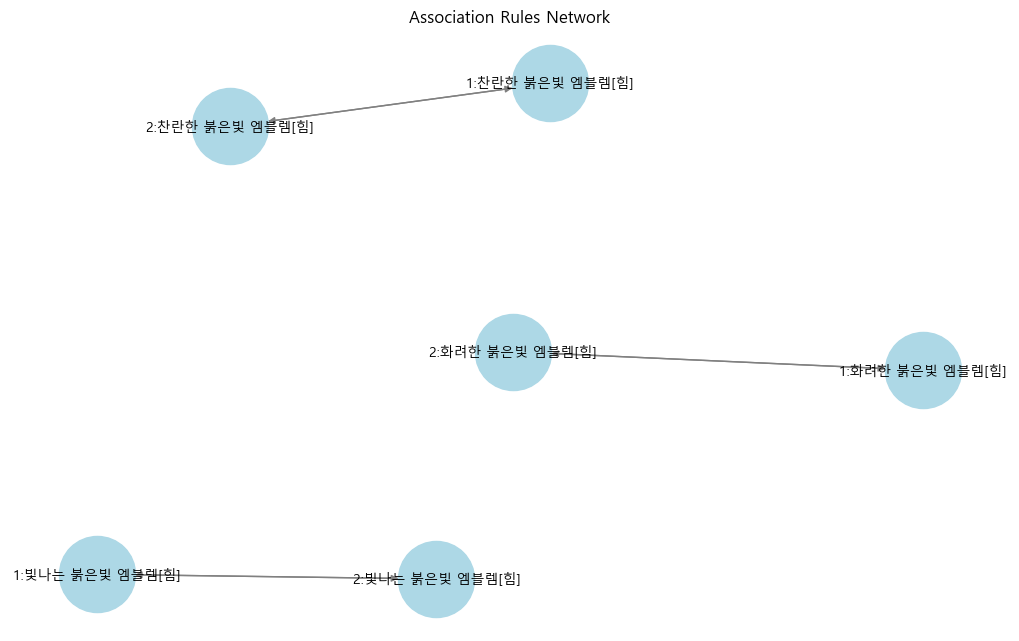

In [38]:
# 네트워크 그래프 시각화
G = nx.DiGraph()
for _, row in rules.iterrows():
    G.add_edge(', '.join(row['antecedents']), ', '.join(row['consequents']), weight=row['confidence'])

plt.figure(figsize=(10,6))
pos = nx.spring_layout(G, k=1)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3000, font_size=10, font_family=font_name)
plt.title("Association Rules Network")
plt.show()

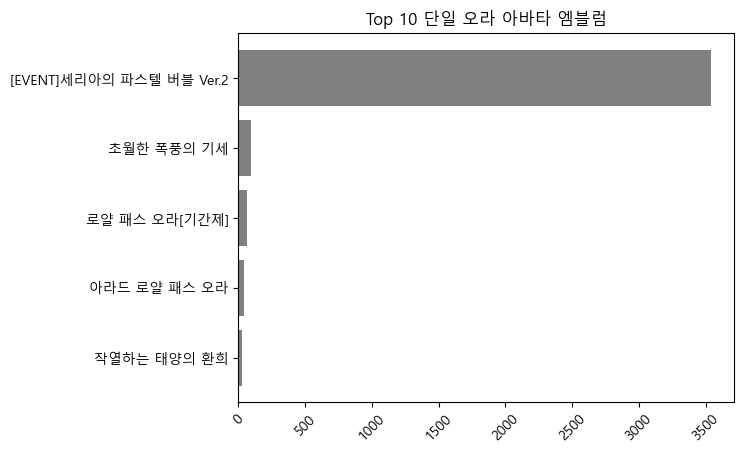

In [39]:
# 오라 아바타 분포
count_aurora_data = Counter(avatar_data[avatar_data["slotName"] == "오라 아바타"]["itemName"])

top_items = count_aurora_data.most_common(5)
names, counts = zip(*top_items)
plt.barh(names, counts, color="gray")
plt.gca().invert_yaxis()
plt.xticks(rotation=45)
plt.title("Top 10 단일 오라 아바타 엠블럼")
plt.show()

In [45]:
# 오라 아바타 엠블럼 분석
avatar_aurora = avatar_data[(avatar_data["slotName"] == "오라 아바타") & (avatar_data["emblems"].notnull())]
print("엠블럼을 쓰는 캐릭터 수: ", len(avatar_aurora))
aurora_list = []

for _, aurora in tqdm(avatar_aurora.iterrows()):
    emblems = aurora["emblems"]
    character_id = aurora["characterId"]
    for emblems_no in emblems:
        row_data = {
            "characterId" : character_id
        }
        emblems_no.update(row_data)
        aurora_list.append(emblems_no)
    
aurora_df = pd.DataFrame(aurora_list)
aurora_df

엠블럼을 쓰는 캐릭터 수:  768


768it [00:00, 61373.04it/s]


,slotNo,slotColor,itemId,itemName,itemRarity,characterId
0,1,다색,7cc772e864bb9f1c1d75ce954928d6fd,화려한 붉은빛 엠블렘[힘],레어,00b5164e28c4e844066417224e74ec47
1,2,다색,7cc772e864bb9f1c1d75ce954928d6fd,화려한 붉은빛 엠블렘[힘],레어,00b5164e28c4e844066417224e74ec47
2,1,다색,bd1b5a935ec9aefd8fdc296b1cac3930,찬란한 붉은빛 엠블렘[힘],유니크,01630028479699dcd0d3221b22fccea6
3,2,다색,bd1b5a935ec9aefd8fdc296b1cac3930,찬란한 붉은빛 엠블렘[힘],유니크,01630028479699dcd0d3221b22fccea6
4,1,다색,7268376c36e42c7c7fc57e8ad7a5c48a,빛나는 녹색빛 엠블렘[마법크리티컬],언커먼,0193a8bafc75086c7d68dc7c27855945
...,...,...,...,...,...,...
1495,2,다색,fd9d6605cb0fed203d2d107f34d2a21d,빛나는 붉은빛 엠블렘[힘],언커먼,ff73098f2988692a1a2563f23a96b021
1496,1,다색,244e0c6469f2d85f94f47d422a73c9c8,찬란한 붉은빛 엠블렘[힘],유니크,ff828280b366c971bb383f853b2cdc85
1497,2,다색,244e0c6469f2d85f94f47d422a73c9c8,찬란한 붉은빛 엠블렘[힘],유니크,ff828280b366c971bb383f853b2cdc85
1498,1,다색,fd9d6605cb0fed203d2d107f34d2a21d,빛나는 붉은빛 엠블렘[힘],언커먼,ffa26394ad36035e8bce9f9e9a0ad5a0


## 3.2 근접 명성 장착 장비 캐릭터 "장착 크리쳐" 분석

In [46]:
# 각 캐릭터 크리쳐 정보 추출
creature_list = []

for idx, personal in tqdm(fame_ranker.iterrows()):
    personal_serverid = personal["serverId"]
    personal_characterid = personal["characterId"]
    url = f"https://api.neople.co.kr/df/servers/{personal_serverid}/characters/{personal_characterid}/equip/creature?apikey={api_key}"

    response = requests.get(url)

    if response.status_code != 200: continue

    personal_creature_data = response.json()
    
    # 크리쳐 유무
    if personal_creature_data["creature"]:
        row_data = {
            "characterId": personal_characterid,
            "itemId": personal_creature_data["creature"]["itemId"],
            "itemName": personal_creature_data["creature"]["itemName"],
            "itemRarity": personal_creature_data["creature"]["itemRarity"]
        }
        
        for art in personal_creature_data["creature"]["artifact"]:
            row_data[art["slotColor"]] = art["itemName"]
    else:
        row_data = {
            "characterId": personal_characterid
        }

    creature_list.append(row_data)
        
creature_data = pd.DataFrame(creature_list)
creature_data.head()

3813it [03:59, 15.95it/s]


,characterId,itemId,itemName,itemRarity,RED,BLUE,GREEN
0,0006341f03cde14187886e6c8a985395,34876e9c7f1018df892617de5dfe6fbc,SD 키라라,레어,조화로운 적룡의 뿔,날카로운 적룡의 날개,차오르는 수호자의 망토
1,001377a613f167003cb028dd4b9c1eb4,c5d3d0419fbb1fcf0157018601b6fc20,[EVENT]다정한 SD 세리아 Ver.2,레어,조화로운 적룡의 뿔,날카로운 적룡의 날개,차오르는 수호자의 망토
2,004a873b3a990550fa7dbdc03f59afa7,c5d3d0419fbb1fcf0157018601b6fc20,[EVENT]다정한 SD 세리아 Ver.2,레어,조화로운 적룡의 뿔,날카로운 적룡의 날개,차오르는 수호자의 망토
3,00553f3c659f5ed023c36a0714678760,c5d3d0419fbb1fcf0157018601b6fc20,[EVENT]다정한 SD 세리아 Ver.2,레어,조화로운 적룡의 뿔,[이벤트]타오르는 영원의 달빛,[이벤트]빛을 머금은 이슬
4,00554d77c6667b10b45b10f6d942d7de,c5d3d0419fbb1fcf0157018601b6fc20,[EVENT]다정한 SD 세리아 Ver.2,레어,조화로운 적룡의 뿔,날카로운 적룡의 날개,차오르는 수호자의 망토


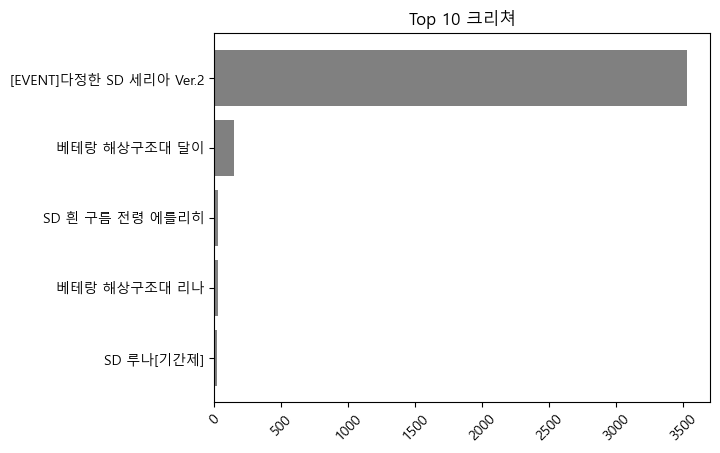

In [189]:
count_creature_data = Counter(creature_data["itemName"])

top_items = count_creature_data.most_common(5)
names, counts = zip(*top_items)
plt.barh(names, counts, color="gray")
plt.gca().invert_yaxis()
plt.xticks(rotation=45)
plt.title("Top 10 크리쳐")
plt.show()

18it [00:00, 19.45it/s]


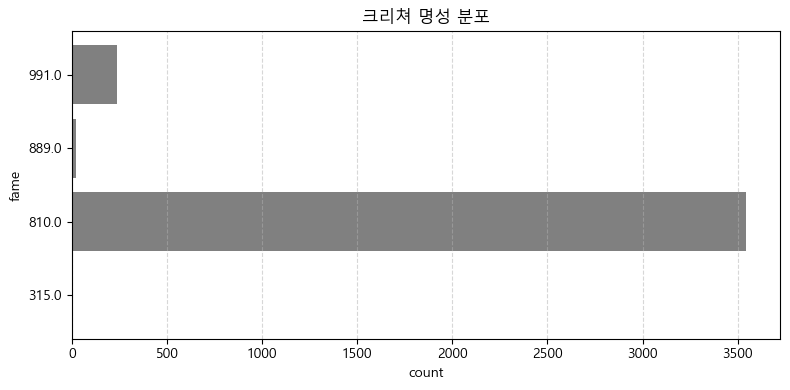

In [188]:
duplicated_creature_data = creature_data.drop_duplicates(subset="itemId")

creature_list = []

for idx, creature_row in tqdm(duplicated_creature_data.iterrows()):
    creature_id = creature_row["itemId"]
    url = f"https://api.neople.co.kr/df/items/{creature_id}?apikey={api_key}"

    response = requests.get(url)
    item = response.json()

    if response.status_code != 200: continue

    row_data = {
        "itemId" : creature_id,
        "fame" : item["fame"]
    }
    creature_list.append(row_data)

fame_creature_data = pd.DataFrame(creature_list)
creature_df = pd.merge(creature_data, fame_creature_data, on="itemId", how="left")

creature_fame = creature_df.groupby("fame").size().reset_index(name="count")

plt.figure(figsize=(8,4))
plt.barh(creature_fame["fame"].astype(str), creature_fame["count"], align = "center", color="gray")

plt.ylabel("fame")
plt.xlabel("count")
plt.title("크리쳐 명성 분포")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# 크리쳐 퍼센트
creature_fame["percent"] = creature_fame["count"] / creature_fame["count"].sum() * 100
creature_fame

,fame,count,percent
0,315.0,3,0.078740
1,810.0,3545,93.044619
2,889.0,24,0.629921
3,991.0,238,6.246719


## 3.3 근접 명성 장착 장비 캐릭터 "버프 스킬 강화 장착 장비" 분석

3813it [03:39, 17.39it/s]


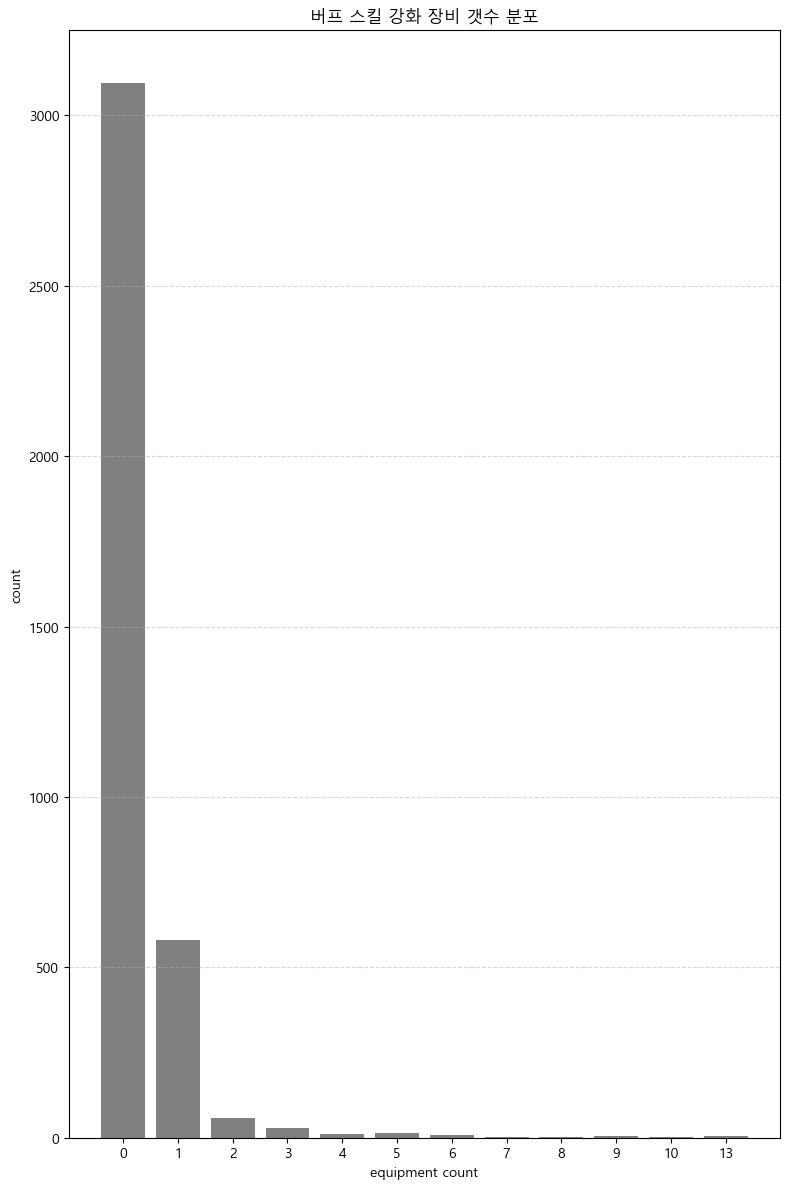

In [52]:
# 캐릭터 버프스킬 강화 장착 장비 추출
buff_equipment_list = []

for idx, personal in tqdm(fame_ranker.iterrows()):
    personal_serverid = personal["serverId"]
    personal_characterid = personal["characterId"]
    url = f"https://api.neople.co.kr/df/servers/{personal_serverid}/characters/{personal_characterid}/skill/buff/equip/equipment?apikey={api_key}"

    response = requests.get(url)
    if response.status_code != 200: continue

    personal_buff_equipment_data = response.json()
    
    if personal_buff_equipment_data["skill"]["buff"]["equipment"]:
        for buff_equipment in personal_buff_equipment_data["skill"]["buff"]["equipment"]:
            row_data = {
            "characterId": personal_characterid
            }
            row_data.update(buff_equipment)
            buff_equipment_list.append(row_data)
    else:
        row_data = {
            "characterId": personal_characterid
        }
        buff_equipment_list.append(row_data)
        
buff_equipment_data = pd.DataFrame(buff_equipment_list)

# 장착한 버프 스킬 강화 장착 장비 갯수 분석
fame_buff_equipment = buff_equipment_data.groupby(["characterId"]).count().reset_index()
fame_buff_equipment_reverse = fame_buff_equipment.groupby(["slotId"]).size().reset_index(name="equip_count")

plt.figure(figsize=(8,12))
plt.bar(fame_buff_equipment_reverse["slotId"].astype(str), fame_buff_equipment_reverse["equip_count"], color="gray")

plt.xlabel("equipment count")
plt.ylabel("count")
plt.title("버프 스킬 강화 장비 갯수 분포")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# 버프 스킬 강화 장비 갯수 비율
fame_buff_equipment_reverse["percent"] = fame_buff_equipment_reverse["equip_count"] / fame_buff_equipment_reverse["equip_count"].sum() * 100
fame_buff_equipment_reverse

,slotId,equip_count,percent
0,0,3095,81.169683
1,1,581,15.237346
2,2,59,1.547338
3,3,29,0.760556
4,4,11,0.288487
5,5,13,0.340939
6,6,9,0.236035
7,7,3,0.078678
8,8,2,0.052452
9,9,5,0.131130


In [ ]:
# 버프 스킬 장비 장착 아이템 비율(장착 장비 갯수 / 1개이상 장착 캐릭터 수)
fame_buff_equipment["percent"] = fame_buff_equipment["count"] / fame_buff_equipment_reverse[fame_buff_equipment_reverse["slotId"]>0]["equip_count"].sum() * 100
fame_buff_equipment

,slotName,count,percent
10,칭호,596,83.008357
4,무기,183,25.487465
8,상의,94,13.091922
12,하의,49,6.824513
2,머리어깨,35,4.874652
9,신발,22,3.064067
6,벨트,22,3.064067
0,귀걸이,20,2.785515
1,마법석,20,2.785515
5,반지,17,2.367688


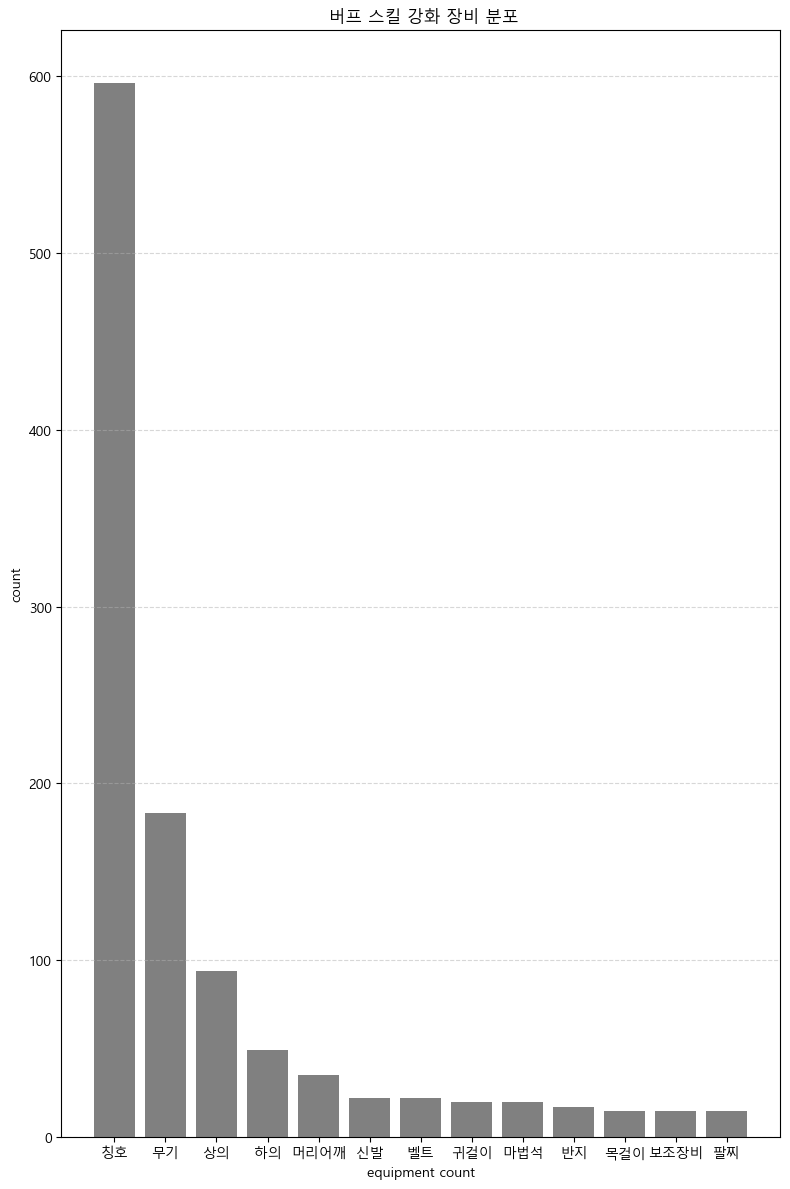

In [56]:
# 장착한 버프 스킬 강화 장착 장비 분포
fame_buff_equipment = buff_equipment_data.groupby(["slotName"]).size().reset_index(name="count").sort_values("count", ascending=False)

plt.figure(figsize=(8,12))
plt.bar(fame_buff_equipment["slotName"], fame_buff_equipment["count"], color="gray")

plt.xlabel("equipment count")
plt.ylabel("count")
plt.title(" 버프 스킬 강화 장비 분포")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

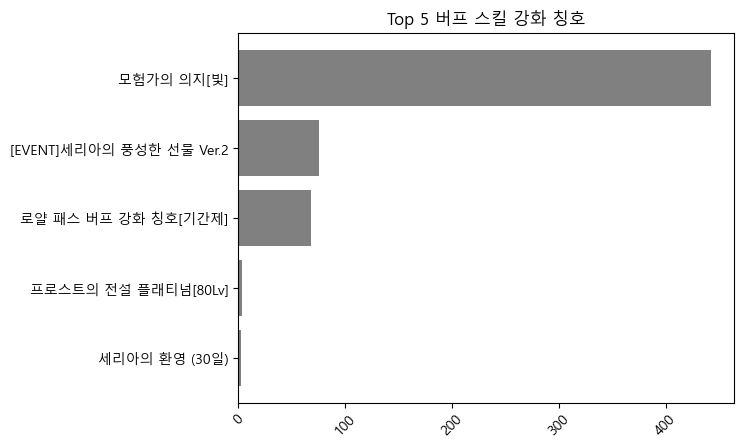

In [57]:
# 버프 스킬 강화 칭호 분포
count_buff_equipment = Counter(buff_equipment_data[buff_equipment_data["slotName"] == "칭호"]["itemName"])

top_items = count_buff_equipment.most_common(5)
names, counts = zip(*top_items)
plt.barh(names, counts, color="gray")
plt.gca().invert_yaxis()
plt.xticks(rotation=45)
plt.title("Top 5 버프 스킬 강화 칭호")
plt.show()

## 3.4 근접 명성 장착 장비 캐릭터 "버프 스킬 강화 장착 아바타" 분석

In [58]:
# 각 캐릭터 버프스킬 강화 장착 아바타 추출
buff_avatar_list = []

for idx, personal in tqdm(fame_ranker.iterrows()):
    personal_serverid = personal["serverId"]
    personal_characterid = personal["characterId"]
    url = f"https://api.neople.co.kr/df/servers/{personal_serverid}/characters/{personal_characterid}/skill/buff/equip/avatar?apikey={api_key}"

    response = requests.get(url)
    if response.status_code != 200: continue

    personal_buff_avatar_data = response.json()
    
    if personal_buff_avatar_data["skill"]["buff"]["avatar"]:
        for buff_avatar in personal_buff_avatar_data["skill"]["buff"]["avatar"]:
            row_data = {
            "characterId": personal_characterid
            }
            row_data.update(buff_avatar)
            buff_avatar_list.append(row_data)
    else:
        row_data = {
            "characterId": personal_characterid
        }
        buff_avatar_list.append(row_data)
        
buff_avatar_data = pd.DataFrame(buff_avatar_list)
buff_avatar_data.head()

3813it [03:46, 16.82it/s]


,characterId,slotId,slotName,itemId,itemName,itemRarity,clone,optionAbility,emblems
0,0006341f03cde14187886e6c8a985395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,001377a613f167003cb028dd4b9c1eb4,JACKET,상의 아바타,6fbe03db226ecda2a37d6a4dc8f4ad6c,진 키메라의 코트[A타입],커먼,"{'itemId': None, 'itemName': None}",복제의 유산 스킬Lv +1,None
2,001377a613f167003cb028dd4b9c1eb4,PANTS,하의 아바타,5cdeb12454121267d95353b620ec3219,진 키메라의 찢어진 스타킹[A타입],커먼,"{'itemId': None, 'itemName': None}",HP MAX 280 증가,None
3,004a873b3a990550fa7dbdc03f59afa7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00553f3c659f5ed023c36a0714678760,JACKET,상의 아바타,60687c19fbc4efbddd66ff5f5306c325,진 키메라의 코트[D타입],커먼,"{'itemId': None, 'itemName': None}",큐브 오브 마테리얼리즘 스킬Lv +1,None


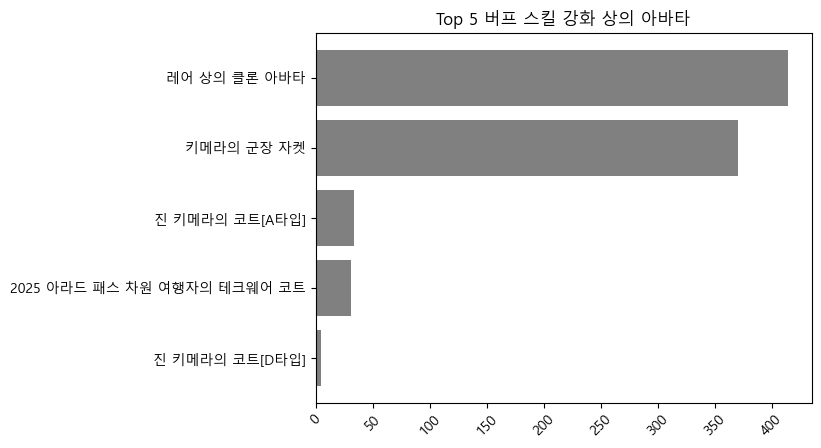

In [59]:
# 버프 스킬 강화 상의 아바타 분포
count_buff_jacket_avatar = Counter(buff_avatar_data[buff_avatar_data["slotName"] == "상의 아바타"]["itemName"])

top_items = count_buff_jacket_avatar.most_common(5)
names, counts = zip(*top_items)
plt.barh(names, counts, color="gray")
plt.gca().invert_yaxis()
plt.xticks(rotation=45)
plt.title("Top 5 버프 스킬 강화 상의 아바타")
plt.show()

524it [00:00, 82494.38it/s]


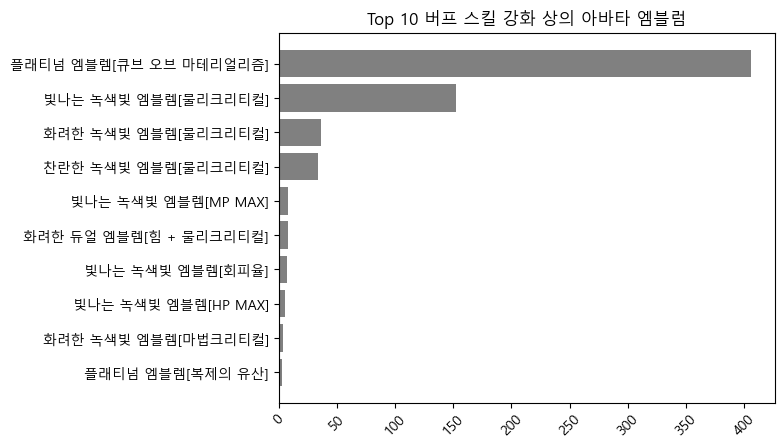

In [63]:
# 버프 스킬 강화 상의 아바타 단일 엠블럼 분포
avatar_jacket = buff_avatar_data[(buff_avatar_data["slotName"] == "상의 아바타") & (buff_avatar_data["emblems"].notnull())]
jacket_list = []

for _, jacket in tqdm(avatar_jacket.iterrows()):
    emblems = jacket["emblems"]
    character_id = jacket["characterId"]
    for emblems_no in emblems:
        row_data = {
            "characterId" : character_id
        }
        emblems_no.update(row_data)
        jacket_list.append(emblems_no)
    
jacket_df = pd.DataFrame(jacket_list)

jacket_group = jacket_df.groupby("characterId")["itemName"].apply(list)
all_jackets = [jacket for sublist in jacket_group for jacket in sublist]
jacket_counts = Counter(all_jackets)

top_jackets = jacket_counts.most_common(10)
names, counts = zip(*top_jackets)
plt.barh(names, counts, color="gray")
plt.xticks(rotation=45)
plt.gca().invert_yaxis()
plt.title("Top 10 버프 스킬 강화 상의 아바타 엠블럼")
plt.show()

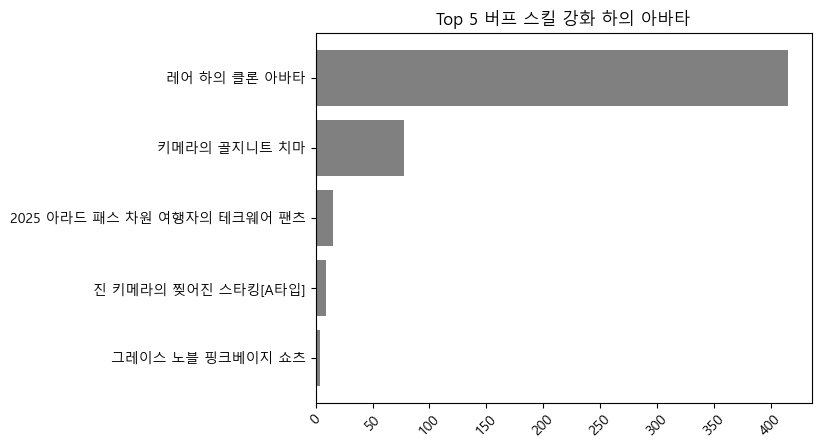

In [64]:
# 버프 스킬 강화 하의 아바타 분포
count_buff_pants_avatar = Counter(buff_avatar_data[buff_avatar_data["slotName"] == "하의 아바타"]["itemName"])

top_items = count_buff_pants_avatar.most_common(5)
names, counts = zip(*top_items)
plt.barh(names, counts, color="gray")
plt.gca().invert_yaxis()
plt.xticks(rotation=45)
plt.title("Top 5 버프 스킬 강화 하의 아바타")
plt.show()

441it [00:00, 57317.35it/s]


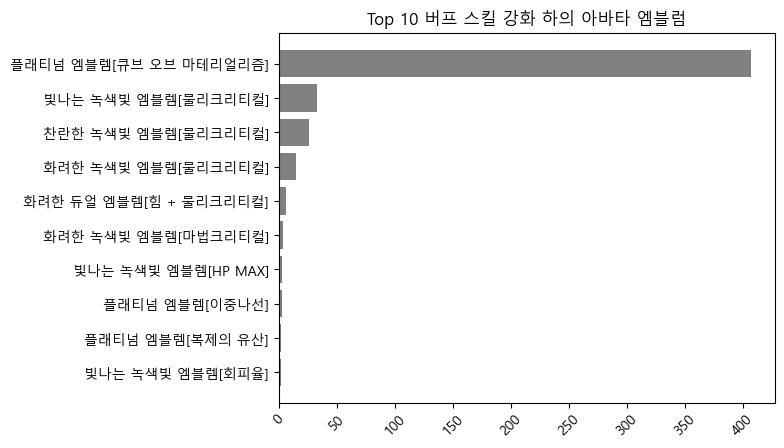

In [66]:
# 버프 스킬 강화 하의 아바타 단일 엠블럼 분포
avatar_pants = buff_avatar_data[(buff_avatar_data["slotName"] == "하의 아바타") & (buff_avatar_data["emblems"].notnull())]
pants_list = []

for _, pants in tqdm(avatar_pants.iterrows()):
    emblems = pants["emblems"]
    character_id = pants["characterId"]
    for emblems_no in emblems:
        row_data = {
            "characterId" : character_id
        }
        emblems_no.update(row_data)
        pants_list.append(emblems_no)
    
pants_df = pd.DataFrame(pants_list)

pants_group = pants_df.groupby("characterId")["itemName"].apply(list)
all_pantss = [pants for sublist in pants_group for pants in sublist]
pants_counts = Counter(all_pantss)

top_pantss = pants_counts.most_common(10)
names, counts = zip(*top_pantss)
plt.barh(names, counts, color="gray")
plt.xticks(rotation=45)
plt.gca().invert_yaxis()
plt.title("Top 10 버프 스킬 강화 하의 아바타 엠블럼")
plt.show()

## 3.5 근접 명성 장착 장비 캐릭터 "버프 스킬 강화 장착 크리처" 분석

In [67]:
# 각 캐릭터 버프스킬 강화 장착 크리쳐 추출
buff_creature_list = []

for idx, personal in tqdm(fame_ranker.iterrows()):
    personal_serverid = personal["serverId"]
    personal_characterid = personal["characterId"]
    url = f"https://api.neople.co.kr/df/servers/{personal_serverid}/characters/{personal_characterid}/skill/buff/equip/creature?apikey={api_key}"

    response = requests.get(url)
    if response.status_code != 200: continue

    personal_buff_creature_data = response.json()
    
    if personal_buff_creature_data["skill"]["buff"]["creature"]:
        for buff_creature in personal_buff_creature_data["skill"]["buff"]["creature"]:
            row_data = {
            "characterId": personal_characterid
            }
            row_data.update(buff_creature)
            buff_creature_list.append(row_data)
    else:
        row_data = {
            "characterId": personal_characterid
        }
        buff_creature_list.append(row_data)
        
buff_creature_data = pd.DataFrame(buff_creature_list)
buff_creature_data.head()

3813it [03:47, 16.73it/s]


,characterId,itemId,itemName,itemRarity,enchant
0,0006341f03cde14187886e6c8a985395,NaN,NaN,NaN,NaN
1,001377a613f167003cb028dd4b9c1eb4,c5d3d0419fbb1fcf0157018601b6fc20,[EVENT]다정한 SD 세리아 Ver.2,레어,None
2,004a873b3a990550fa7dbdc03f59afa7,NaN,NaN,NaN,NaN
3,00553f3c659f5ed023c36a0714678760,ade43766ae111d6ee0c64d033f77cb10,파핑파핑 8비트 아처,레어,{'reinforceSkill': [{'jobId': '41f1cdc2ff58bb5...
4,00554d77c6667b10b45b10f6d942d7de,NaN,NaN,NaN,NaN


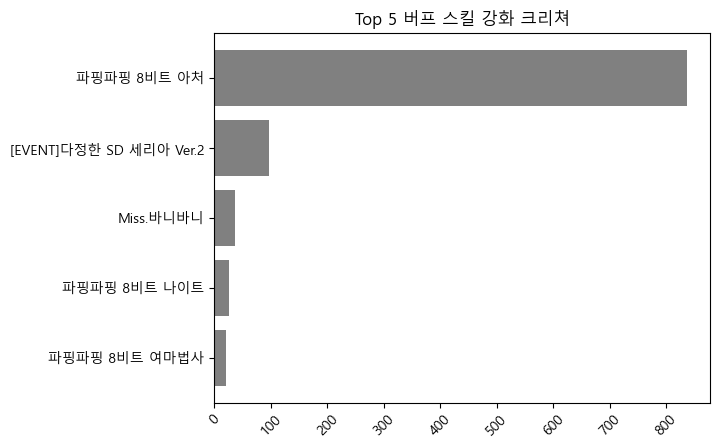

In [187]:
# 버프 스킬 강화 크리쳐 분포
count_buff_creature_avatar = Counter(buff_creature_data[buff_creature_data["itemName"].notnull()]["itemName"])
top_items = count_buff_creature_avatar.most_common(5)
names, counts = zip(*top_items)
plt.barh(names, counts, color="gray")
plt.gca().invert_yaxis()
plt.xticks(rotation=45)
plt.title("Top 5 버프 스킬 강화 크리쳐")
plt.show()

## 분석 결과

- 아바타
    - 캐릭터 3813명 중 스킨 아바타에 엠블렘을 쓰는 사람은 253명으로 10%도 안된다. 또한, 오라 아바타에 엠블렘을 쓰는 사람은 768명으로 약 20%정도 사용한다.
    그만큼 이벤트로 제공한 엠블렘이 아닌 구매하는 부분의 엠블렘 사용 비중이 크지 않다.
    - 오라 아바타는 3539명이 이벤트로 받은 오라 아바타를 사용한다.
    - 대부분의 캐릭터는 동일한 엠블렘으로 소켓에 넣는다.

- 크리쳐
    - 대부분 이벤트 크리쳐를 사용하지만 6%는 종결 크리쳐(명성 991)을 사용한다.
    - 종결 크리쳐는 최근 해상구조대 패키지에 포함되어있는 "베테랑 해상구조대 달이", 프리미엄 코인으로 구매하거나 로얄 패스로 무제한으로 변환가능한 "SD 흰 구름 전령 에를리히", 해상 구조대 패키지에서 적은 확률로 획득 가능한 "베테랑 해상구조대 리나" 순으로 많이 사용하고 있다.
    - 신기한 점은 오라 아바타에서는 "로얄 패스 오라[기간제]"가 무제한인 "아라드 로얄 패스 오라" 보다 높았으나 크리쳐에서는 "SD 흰 구름 전령 에를리히"의 기간제를 찾아볼 수 없다.

- 버프 스킬 강화 장비
    - 버프 스킬 강화 장비를 착용하지 않는 캐릭터가 3095명으로 약 80%를 차지한다.
    - 1개이상 착용하는 캐릭터 중 칭호를 장착하고 있는 캐릭터는 83%이며 그 다음으로는 무기로 25%를 차지하고 있다.
    - 버프 스킬 강화 칭호로는 이누야사 패키지로 받을 수 있는 "모험가의 의지"를 많이 장착하고 있으며, 속성마다 스킬 올려주는 레벨 구간이 다르며 "키메라"의 경우 "빛"을 받는 것을 확인할 수 있다.
    - 다음으로는 캐릭터 육성하면 받을 수 있는 "[EVENT]세리아의 풍성한 선물 Ver.2", 로얄 패스 기간제로 받을 수 있는"로얄 패스 버프 강화 칭호[기간제]"순으로 많이 사용한다.

- 버프 스킬 강화 아바타
    - 버프 스킬 강화 아바타로 종결인 "레어 (하의/상의) 클론 아바타"를 많이 사용하고 있다.
    - 가장 많이 사용하는 엠블럼으로는 "플래티넘 엠블렘[큐브 오브 마테리얼리즘]", 다음은 언커먼인 "빛나는 녹색빛 엠블렘[물리크리티컬]"이다. 상의의 경우 레어인 "화려한", 유니크인 "찬란한"순으로 많이 사용한다. 하지만 하의의 경우 유니크, 레어 순으로 반대이다.

- 버프 스킬 강화 크리쳐
    - "디그밍의 여름을 부탁해"와 "미라클의 썸머 바캉스 계획표" 이벤트에서 얻을 수 있는 "파팡파팡 8비트 모험가 크리쳐+보주 상자"로 인하여 "파팡파팡 8비트 아처가 가장 많은 것을 확인할 수 있다.

- 결론
    - 스킨 아바타 엠블럼 사용은 10%미만으로 후순위로 미뤄도 괜찮을 거 같다.
    - 종결 크리쳐와 오라의 가격을 비교해보고 결정 -> 로얄 패스 크리쳐를 무제한으로 사용하는 것으로 보아 크리쳐가 더 비싼것으로 예상
    - 버프 스킬 강화 장비 "모험가의 의지" 가격 확인 필요. 무기 및 다른 장비는 "미라클의 썸머 바캉스 계획표"에서 2개 구매 예정
    - "레어 (하의/상의) 클론 아바타" 가격 확인 필요 -> 후 엠블럼 가격 확인

# 4. 가격 비교

In [ ]:
# 오라 vs 크리쳐 가격 비교(패스 무제한 변견권 선택 이유)
lst = ["베테랑 해상구조대 달이", "SD 흰 구름 전령 에를리히", "베테랑 해상구조대 리나", "초월한 폭풍의 기세", "작렬하는 태양의 환희"]

word_type = "front"
limit = "1"
sort_price = "asc"

row_data = []

for item in lst:
    encoding_name = parse.quote(item)
    # 경매장 검색
    url = f"https://api.neople.co.kr/df/auction?itemName={encoding_name}&wordType={word_type}&wordShort=true&sort=unitPrice:{sort_price}&limit={limit}&apikey={api_key}"
    response = requests.get(url)
    data = response.json()

    if not data["rows"]: continue

    data = data["rows"][0]
    row_list = {
        "itemId": data["itemId"],
        "itemName": data["itemName"],
        "itemRarity": data["itemRarity"],
        "itemTypeDetail": data["itemTypeDetail"],
        "unitPrice": data["unitPrice"],
        "averagePrice": data["averagePrice"]
    }
    item_id = data["itemId"]

    # 아이템 상세 정보 조회
    url = f"https://api.neople.co.kr/df/items/{item_id}?apikey={api_key}"
    response = requests.get(url)
    item_data = response.json()
    
    if "itemStatus" in item_data.keys():
        for status in item_data["itemStatus"]:
            status_data = {
                status["name"]: status["value"]
            }
            row_list.update(status_data)
        row_data.append(row_list)
    else:
        item_id = avatar_data[avatar_data["itemName"] == item]["itemId"].iloc[0]

        url = f"https://api.neople.co.kr/df/items/{item_id}?apikey={api_key}"
        response = requests.get(url)
        item_detail_data = response.json()
        for status in item_detail_data["itemStatus"]:
            status_data = {
                status["name"]: status["value"]
            }
            row_list.update(status_data)
        row_data.append(row_list)

price_pass = pd.DataFrame(row_data)
price_pass.sort_values(["unitPrice"], axis=0)

,itemId,itemName,itemRarity,itemTypeDetail,unitPrice,averagePrice,모험가 명성,힘,체력,지능,...,물리 크리티컬 히트,모든 속성 강화,MP MAX,마법 크리티컬 히트,공격력 증폭,버프력 증폭,물리 공격력,마법 공격력,독립 공격력,마을 이동 속도 증가
0,246f524acf7f4436676081234fdd0549,베테랑 해상구조대 달이 알,레어,크리쳐,22000000,22931621,991,110,110,110,...,3%,30,5%,3%,25%,7%,NaN,NaN,NaN,NaN
3,3694eeead72b7f189b59b40eb6029c4f,초월한 폭풍의 기세 오라 상자,레어,선택 부스터,31988000,31599208,645,100,100,100,...,5%,40,NaN,5%,6%,4%,50.0,50.0,50.0,10%
2,865723951f48891e4109dcf8313355a3,베테랑 해상구조대 리나 알,레어,크리쳐,33000000,29900000,991,110,110,110,...,3%,30,5%,3%,25%,7%,NaN,NaN,NaN,NaN
1,1ca719543274a0ae0b12b478d88c0448,SD 흰 구름 전령 에를리히 알,레어,크리쳐,68999998,68000000,991,110,110,110,...,3%,30,5%,3%,25%,7%,NaN,NaN,NaN,NaN


In [ ]:
# 스킨 아바타 엠블럼 가격 비교
lst = ["찬란한 붉은빛 엠블렘[힘]", "화려한 붉은빛 엠블렘[힘]", "빛나는 붉은빛 엠블렘[힘]"]

word_type = "match"
limit = "1"
sort_price = "asc"

row_data = []

for item in lst:
    encoding_name = parse.quote(item)
    # 경매장 검색
    url = f"https://api.neople.co.kr/df/auction?itemName={encoding_name}&wordType={word_type}&wordShort=true&sort=unitPrice:{sort_price}&limit={limit}&apikey={api_key}"
    response = requests.get(url)
    data = response.json()
    data = data["rows"][0]
    row_list = {
        "itemId": data["itemId"],
        "itemName": data["itemName"],
        "itemRarity": data["itemRarity"],
        "itemTypeDetail": data["itemTypeDetail"],
        "unitPrice": data["unitPrice"],
        "averagePrice": data["averagePrice"]
    }
    item_id = data["itemId"]

    # 아이템 상세 정보 조회
    url = f"https://api.neople.co.kr/df/items/{item_id}?apikey={api_key}"
    response = requests.get(url)
    item_data = response.json()

    for status in item_data["itemStatus"]:
        status_data = {
            status["name"]: status["value"]
        }
        row_list.update(status_data)
    row_data.append(row_list)

price_slot = pd.DataFrame(row_data)
price_slot.sort_values(["unitPrice"], axis=0)

,itemId,itemName,itemRarity,itemTypeDetail,unitPrice,averagePrice,모험가 명성,힘
2,fd9d6605cb0fed203d2d107f34d2a21d,빛나는 붉은빛 엠블렘[힘],언커먼,엠블렘,38888,60009,26,10
1,7cc772e864bb9f1c1d75ce954928d6fd,화려한 붉은빛 엠블렘[힘],레어,엠블렘,629000,631852,30,17
0,5d45377b59fef23c3c77e7bc9c65d5e6,찬란한 붉은빛 엠블렘[힘],유니크,엠블렘,7899999,7985369,36,25


In [138]:
# 버프 아바타 엠블럼 가격 비교
lst = ["플래티넘 엠블렘[큐브 오브 마테리얼리즘]", "빛나는 녹색빛 엠블렘[물리크리티컬]", "화려한 녹색빛 엠블렘[물리크리티컬]", "찬란한 녹색빛 엠블렘[물리크리티컬]"]

word_type = "match"
limit = "1"
sort_price = "asc"

row_data = []

for item in lst:
    encoding_name = parse.quote(item)
    # 경매장 검색
    url = f"https://api.neople.co.kr/df/auction?itemName={encoding_name}&wordType={word_type}&wordShort=true&sort=unitPrice:{sort_price}&limit={limit}&apikey={api_key}"
    response = requests.get(url)
    data = response.json()
    data = data["rows"][0]
    row_list = {
        "itemId": data["itemId"],
        "itemName": data["itemName"],
        "itemRarity": data["itemRarity"],
        "itemTypeDetail": data["itemTypeDetail"],
        "unitPrice": data["unitPrice"],
        "averagePrice": data["averagePrice"]
    }
    item_id = data["itemId"]

    # 아이템 상세 정보 조회
    url = f"https://api.neople.co.kr/df/items/{item_id}?apikey={api_key}"
    response = requests.get(url)
    item_data = response.json()

    for status in item_data["itemStatus"]:
        status_data = {
            status["name"]: status["value"]
        }
        row_list.update(status_data)
    row_data.append(row_list)

price_buff_slot = pd.DataFrame(row_data)
price_buff_slot.sort_values(["unitPrice"], axis=0)

,itemId,itemName,itemRarity,itemTypeDetail,unitPrice,averagePrice,모험가 명성,힘,체력,지능,정신력,물리 크리티컬 히트
1,a4473d548a61f0c68aeace838fdac90c,빛나는 녹색빛 엠블렘[물리크리티컬],언커먼,엠블렘,17000,24800,26,NaN,NaN,NaN,NaN,1.2%
2,aa9cb55f3b8f4b0b2146f8f49a5f1ad6,화려한 녹색빛 엠블렘[물리크리티컬],레어,엠블렘,172999,195900,30,NaN,NaN,NaN,NaN,2.2%
3,b48e55e72a590c64b0066b58ba007d6a,찬란한 녹색빛 엠블렘[물리크리티컬],유니크,엠블렘,999999,965125,36,NaN,NaN,NaN,NaN,3%
0,971ce89fbe6a9aedcbef79d7bb0e5672,플래티넘 엠블렘[큐브 오브 마테리얼리즘],레전더리,엠블렘,1500000,1701930,232,8.0,8.0,8.0,8.0,NaN


In [139]:
# 버프 장비 가격 비교
lst = ["모험가의 의지[빛]", "레어 상의 클론 아바타", "레어 하의 클론 아바타"]

word_type = "match"
limit = "1"
sort_price = "asc"

row_data = []

for item in lst:
    encoding_name = parse.quote(item)
    # 경매장 검색
    url = f"https://api.neople.co.kr/df/auction?itemName={encoding_name}&wordType={word_type}&wordShort=true&sort=unitPrice:{sort_price}&limit={limit}&apikey={api_key}"
    response = requests.get(url)
    data = response.json()
    data = data["rows"][0]
    row_list = {
        "itemId": data["itemId"],
        "itemName": data["itemName"],
        "itemRarity": data["itemRarity"],
        "itemTypeDetail": data["itemTypeDetail"],
        "unitPrice": data["unitPrice"],
        "averagePrice": data["averagePrice"]
    }
    item_id = data["itemId"]

    # 아이템 상세 정보 조회
    url = f"https://api.neople.co.kr/df/items/{item_id}?apikey={api_key}"
    response = requests.get(url)
    item_data = response.json()

    for status in item_data["itemStatus"]:
        status_data = {
            status["name"]: status["value"]
        }
        row_list.update(status_data)
    row_data.append(row_list)

price_buff = pd.DataFrame(row_data)
price_buff.sort_values(["unitPrice"], axis=0)

,itemId,itemName,itemRarity,itemTypeDetail,unitPrice,averagePrice,모험가 명성,힘,체력,지능,정신력,HP MAX,MP MAX,공격속도,이동속도,캐스트속도,적중률,물리 크리티컬 히트,마법 크리티컬 히트,마을 이동 속도 증가
1,b9f2f716a09d0ed96d115ed5776aa5db,레어 상의 클론 아바타,레어,상의,8600000,8988919,88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,f0a7f91f0e663c5726ee6f041133319d,레어 하의 클론 아바타,레어,하의,8775555,8800003,88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,5556566f09bb895cb36ad1164bf8231c,모험가의 의지[빛],레어,칭호,11000000,38510417,491,40.0,40.0,40.0,40.0,200.0,200.0,3%,3%,3%,3%,3%,3%,10%


In [140]:
total_price_data = pd.concat([price_pass, price_slot, price_buff_slot,price_buff])
total_price_data.sort_values(["unitPrice"])

,itemId,itemName,itemRarity,itemTypeDetail,unitPrice,averagePrice,모험가 명성,힘,체력,지능,...,MP MAX,마법 크리티컬 히트,공격력 증폭,버프력 증폭,물리 공격력,마법 공격력,독립 공격력,마을 이동 속도 증가,HP MAX,적중률
1,a4473d548a61f0c68aeace838fdac90c,빛나는 녹색빛 엠블렘[물리크리티컬],언커먼,엠블렘,17000,24800,26,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,fd9d6605cb0fed203d2d107f34d2a21d,빛나는 붉은빛 엠블렘[힘],언커먼,엠블렘,38888,60009,26,10.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,aa9cb55f3b8f4b0b2146f8f49a5f1ad6,화려한 녹색빛 엠블렘[물리크리티컬],레어,엠블렘,172999,195900,30,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7cc772e864bb9f1c1d75ce954928d6fd,화려한 붉은빛 엠블렘[힘],레어,엠블렘,629000,631852,30,17.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,b48e55e72a590c64b0066b58ba007d6a,찬란한 녹색빛 엠블렘[물리크리티컬],유니크,엠블렘,999999,965125,36,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,971ce89fbe6a9aedcbef79d7bb0e5672,플래티넘 엠블렘[큐브 오브 마테리얼리즘],레전더리,엠블렘,1500000,1701930,232,8.0,8.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,5d45377b59fef23c3c77e7bc9c65d5e6,찬란한 붉은빛 엠블렘[힘],유니크,엠블렘,7899999,7985369,36,25.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,b9f2f716a09d0ed96d115ed5776aa5db,레어 상의 클론 아바타,레어,상의,8600000,8988919,88,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,f0a7f91f0e663c5726ee6f041133319d,레어 하의 클론 아바타,레어,하의,8775555,8800003,88,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,5556566f09bb895cb36ad1164bf8231c,모험가의 의지[빛],레어,칭호,11000000,38510417,491,40.0,40.0,40.0,...,200.0,3%,NaN,NaN,NaN,NaN,NaN,10%,200.0,3%


In [186]:
# 스킨 아바타 엠블럼 + 소캣 생성기
price = total_price_data[total_price_data["itemName"] == "찬란한 붉은빛 엠블렘[힘]"]["unitPrice"].iloc[0]
total_price = price * 2 + 1800000
print(total_price)

17599998


In [161]:
# 버프 강화 아바타 가격(종결)
price1 = total_price_data[total_price_data["itemName"] == "레어 상의 클론 아바타"]["unitPrice"].iloc[0]
price2 = total_price_data[total_price_data["itemName"] == "레어 하의 클론 아바타"]["unitPrice"].iloc[0]
price3 = total_price_data[total_price_data["itemName"] == "플래티넘 엠블렘[큐브 오브 마테리얼리즘]"]["unitPrice"].iloc[0]
price4 = total_price_data[total_price_data["itemName"] == "찬란한 녹색빛 엠블렘[물리크리티컬]"]["unitPrice"].iloc[0]

total_price = price1 + price2 + price3 * 2 + price4 * 4
print(total_price)

24375551


## 결론

- 현재 골드: `1700만 골드`

- 가격 비교
    - 가장 가격이 낮은 크리쳐는 2200만 골드, 오라 아바타는 3198만 골드로 오라 아바타가 크리쳐보다 높다. 하지만, "SD 흰 구름 전령 에를리히 알"은 6899만 골드로 가격이 가장 높은 것을 확인할 수 있다. 그러므로 "SD 흰 구름 전령 에를리히"의 외형이 마음에 든다면 무제한권을 사용해도 비용적으로는 나쁘지않은 선택이다.
    - 버프 스킬 강화 아바타 및 엠블렘 총 가격은 2437만원으로 현재는 구입이 불가능하다.
    - 버프 스킬 강화 칭호인 "모험가의 의지[빛]]"은 1100만원으로 구입이 가능하다.
    - 스킨 아바타 엠블렘 및 소캣 생성기는 1759만원으로 구입은 가능하나 엠블렘을 사용하는 캐릭터가 10%도 안되어 우선순위에서 밀린다.

- 우선순위
    - "SD 흰 구름 전령 에를리히" 무제한 변경
    - "모험가의 의지[빛]]"
    - 버프 스킬 강화 아바타 + 엠블렘
    - 오라 아바타
    - 스킨 아바타 엠블렘 및 소캣 생성기

※ 추가
- 이벤트로 버프 스킬 강화 칭호를 지급하는 경우가 있어 기다리는 방법도 가능하다.(8월 20주년 이벤트에 나올 가능성이 있음)